# Fitting PKS 2155-304

- Do not care if fake or real data
- We do not know anything about the models used to simulate the data
- We (of course) know the observation conditions 

In [1]:
import matplotlib.pyplot as plt

In [142]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator

In [3]:
#read the dataset
cta_dataset = MapDataset.read("pks2155-simulated.fits.gz", name="cta_dataset")

In [4]:
print(cta_dataset)

MapDataset
----------

  Name                            : cta_dataset 

  Total counts                    : 55515 
  Total background counts         : 52917.67
  Total excess counts             : 2597.33

  Predicted counts                : 52917.67
  Predicted background counts     : 52917.67
  Predicted excess counts         : nan

  Exposure min                    : 4.64e+07 m2 s
  Exposure max                    : 3.58e+10 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Data Fitting
- What is the significance of the detected source?
- Can we detect a cutoff in the observed spectrum?
- H0: Background only
- H1: Power law model
- H2: Cutoff power law

This logic can be generalised to other questions - is the source extended/variable/etc

In [5]:
#explain global Models object
models = Models()

In [6]:
## Background only
bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)
cta_dataset.models = models

In [7]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[cta_dataset])

CPU times: user 113 ms, sys: 8.52 ms, total: 122 ms
Wall time: 123 ms


In [8]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 23
	total stat : 162167.74

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [9]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str3,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,1.0491e+00,,4.453e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [10]:
L0 = result.total_stat
print(L0)

162167.73504597833


### Now, add a source model

In [11]:
src_pos = SkyCoord.from_name("PKS 2155-304")

In [12]:
spectral_model = ExpCutoffPowerLawSpectralModel()
spatial_model = PointSpatialModel()
pks_model = SkyModel(spectral_model=spectral_model,
                     spatial_model=spatial_model, 
                    name="pks_model")

In [13]:
spectral_model.amplitude.value = 1e-12
spectral_model.index.value = 2.0
spectral_model.lambda_.value = 0.0
spectral_model.lambda_.frozen = True # Behaves as a power law, cutoff fixed at infty

spatial_model.lon_0.value = src_pos.ra.value
spatial_model.lat_0.value = src_pos.dec.value

In [14]:
models.append(pks_model)

In [15]:
cta_dataset.models = models

In [16]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[cta_dataset])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (349.11422142, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (349.11422142, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (310.3196551, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (310.3196551, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (331.65666658, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (331.65666658, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (327.77720994, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
P

CPU times: user 9.3 s, sys: 266 ms, total: 9.56 s
Wall time: 9.6 s


In [17]:
result2

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 188
	total stat : 152644.03

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [18]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,9.9538e-01,,4.360e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,index,2.8726e+00,,2.427e-02,nan,nan,False,
pks_model,spectral,amplitude,4.2104e-12,cm-2 s-1 TeV-1,1.542e-13,nan,nan,False,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
pks_model,spatial,lon_0,3.2971e+02,deg,1.319e-03,nan,nan,False,


In [19]:
L1 = result2.total_stat
print("del TS of detection: ", (L0-L1))

del TS of detection:  9523.703250152117


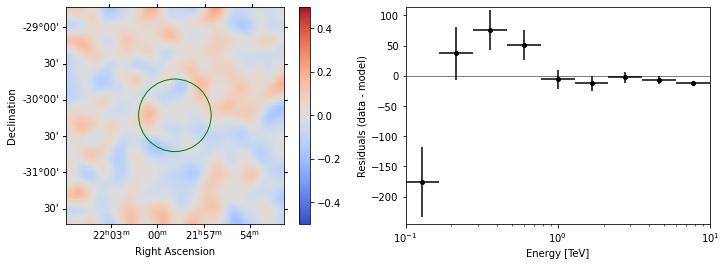

In [20]:
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

#### Get flux points

In [21]:
energy_edges = np.logspace(-1, 1, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name)

In [22]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

CPU times: user 5.72 s, sys: 71.7 ms, total: 5.79 s
Wall time: 5.79 s


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (TeV / (cm2 s))'>

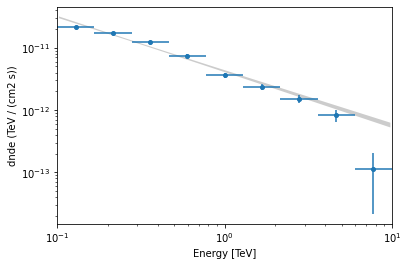

In [23]:
ax = spectral_model.plot_error(energy_bounds=[0.1,10]*u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

### Now, search for cutoff

In [24]:
spectral_model.lambda_.frozen = False

In [25]:
%%time
fit3 = Fit(optimize_opts={"print_level": 1})
result3 = fit3.run(datasets=[cta_dataset])

CPU times: user 1.83 s, sys: 17.8 ms, total: 1.85 s
Wall time: 1.85 s


In [26]:
result3.success

True

In [27]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,9.9571e-01,,4.361e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,index,2.6431e+00,,5.150e-02,nan,nan,False,
pks_model,spectral,amplitude,6.4965e-12,cm-2 s-1 TeV-1,6.034e-13,nan,nan,False,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,lambda_,3.2053e-01,TeV-1,6.743e-02,nan,nan,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
pks_model,spatial,lon_0,3.2971e+02,deg,1.315e-03,nan,nan,False,


In [28]:
L2 = result3.total_stat
print("del TS of cutoff: ",(L1-L2))

del TS of cutoff:  30.97094132975326


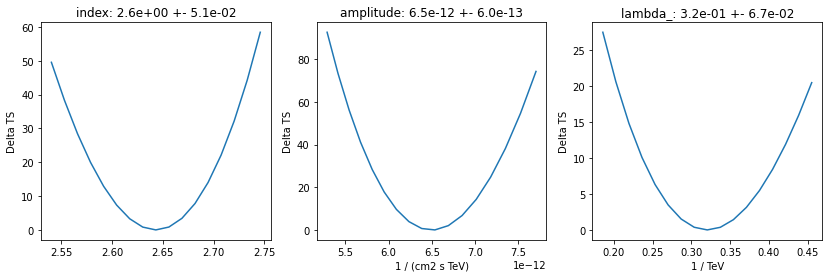

In [29]:
### See a likelihood scan of free parameters
total_stat = result3.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit.stat_profile(datasets=[cta_dataset], parameter=par)
    ax.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

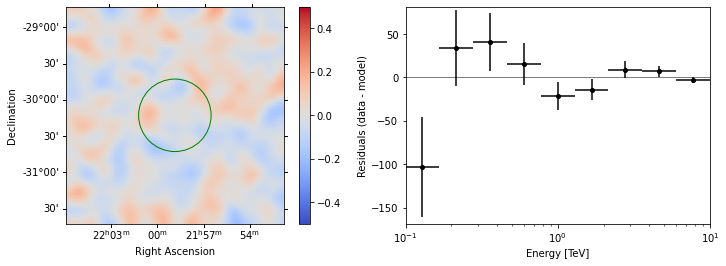

In [30]:
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

#### Get flux points

In [31]:
energy_edges = np.logspace(-1, 1, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name)

In [32]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

CPU times: user 5.65 s, sys: 67.9 ms, total: 5.72 s
Wall time: 5.73 s


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (TeV / (cm2 s))'>

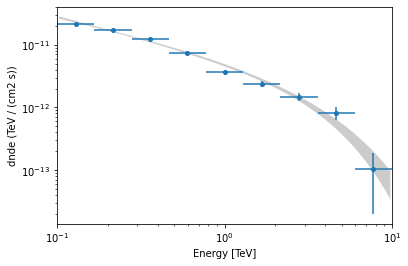

In [33]:
ax = spectral_model.plot_error(energy_bounds=[0.1,10]*u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

We have successfully detected a cutoff in the observed spectrum.

**Exercise**: Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/0.19/modeling/gallery/index.html 
You can also try creating your own models.

## 2. Joint Fitting with Fermi-LAT

Aim: Simulatneously fit the CTA flux points with 4FGL flux points.

In [179]:
model_copy = pks_model.copy()
spec = LogParabolaSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
model_fp = SkyModel(spec*ebl, name="model_fp")

In [180]:
fermi_catalag = SourceCatalog4FGL()
source = fermi_catalag["PKS 2155-304"]
fermi_flux_points = source.flux_points

In [181]:
fermi_fp_dataset = FluxPointsDataset(data=fermi_flux_points, models=model_fp, name="fermi")
cta_fp_dataset = FluxPointsDataset(data=flux_points, models=model_fp, name="cta")
datasets = Datasets([fermi_fp_dataset, cta_fp_dataset])

In [182]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : fermi
  Instrument : 
  Models     : ['model_fp']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : cta
  Instrument : 
  Models     : ['model_fp']




In [183]:
%%time
fit4 = Fit(optimize_opts={"print_level": 0})
result4 = fit4.run(datasets=datasets)

/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/Gammapy-dev/gammapy/gammapy/datasets/flux_points.py:218: RuntimeWarning: overflow encountered in square
  return ((data - model) / sigma.quantity[:, 0, 0]).to_value("") ** 2


CPU times: user 2.12 s, sys: 13.4 ms, total: 2.13 s
Wall time: 2.13 s


In [184]:
model_fp.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str10,float64,str14,float64,float64,float64,bool,str1
spectral,amplitude,5.2364e-14,cm-2 s-1 TeV-1,2.555e-15,nan,nan,False,
spectral,reference,1.0000e+01,TeV,0.000e+00,nan,nan,True,
spectral,alpha,2.5067e+00,,1.750e-02,nan,nan,False,
spectral,beta,4.0775e-02,,1.403e-03,nan,nan,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,


In [185]:
pks_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,index,2.6431e+00,,5.150e-02,nan,nan,False,
spectral,amplitude,6.4965e-12,cm-2 s-1 TeV-1,6.034e-13,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spectral,lambda_,3.2053e-01,TeV-1,6.743e-02,nan,nan,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
spatial,lon_0,3.2971e+02,deg,1.315e-03,nan,nan,False,
spatial,lat_0,-3.0224e+01,deg,1.157e-03,-9.000e+01,9.000e+01,False,


(<AxesSubplot:xlabel='Energy [MeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot:xlabel='Energy [MeV]', ylabel='Residuals\n (data - model) / model'>)

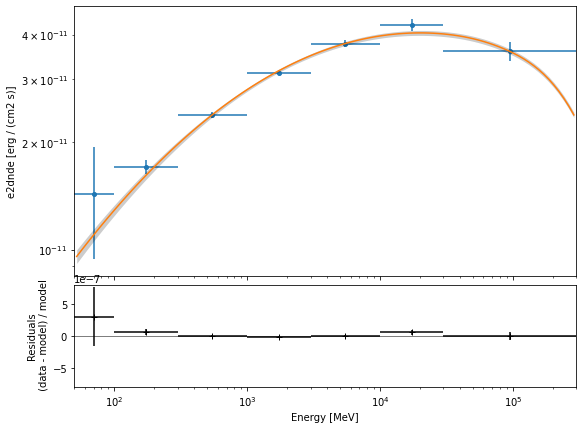

In [186]:
fermi_fp_dataset.plot_fit()

(<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals\n (data - model) / model'>)

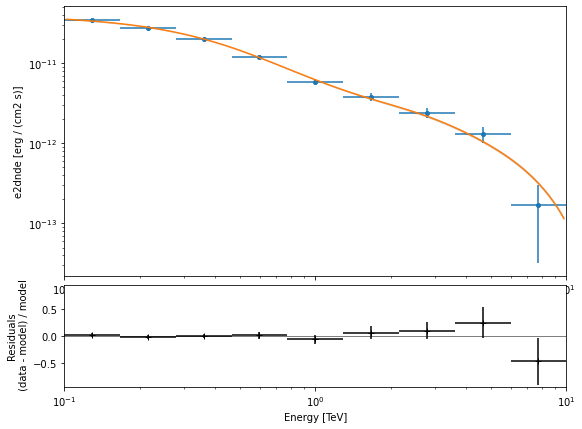

In [187]:
cta_fp_dataset.plot_fit()

You can extend this
- share one EBL model among 10 blazars
- each blazar has its own intrisic model
- perform a joint fit across 10 datasets

or
- take a blazar in flare and quiescent state
- quiescent model to be shared among the two datasets
- add an extra model to the flare dataset


add your science case...

## Exercise:

 - Fit a joint Fermi-CTA spectra using a Logparabola and EBL model.
**Note**: Pay attention to known bug for CompoundModels: https://github.com/gammapy/gammapy/discussions/3705 

- Pick your favourite SNR from the 4FGL and HGPS catalog. Do a joint fit.
Interface with a naima spectral model to directly fit the particle spectrum https://docs.gammapy.org/0.19/modeling/gallery/spectral/plot_naima.html?highlight=naima